In [238]:
# !! This notebook is only for experimentation purposes, in order to show the steps taken to select the best model. Thus, the parameters/features/model is subject to change in the future.
import warnings

from time import perf_counter
from typing import Dict, List
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

warnings.filterwarnings('ignore')

In [239]:
with open('../data/trips_data.csv', 'r') as f:
    trip_data = pd.read_csv(f)

In [240]:
trip_data

,trip_id,subtrip_id,date,day_of_week,train_id,train_type,initial_departure_station,final_arrival_station,route,current_station,...,dew_point_on_arrival,apparent_temperature_on_arrival,precipitation_on_arrival,visibility_on_arrival,wind_speed_on_arrival,wind_direction_on_arrival,wind_gusts_on_arrival,uv_index_on_arrival,cloud_cover_on_arrival,surface_pressure_on_arrival
0,475a318f125109daa63f2d22bbc975d685afbc3e2aadb5...,9ecce6061fb759c37f51dcd0578a3514724cb3d7d3da19...,2025-05-19,0,1,TNR,CASA PORT,KENITRA,CASA PORT - KENITRA,CASA PORT,...,14.521266,17.952110,0.0,23160.0,5.411986,93.814000,14.040000,0.00,62.0,1014.91310
1,475a318f125109daa63f2d22bbc975d685afbc3e2aadb5...,c457d66f9f93dff1bcb117f0c6b78947f552efd2634588...,2025-05-19,0,1,TNR,CASA PORT,KENITRA,CASA PORT - KENITRA,AIN SEBAA,...,14.502754,17.370037,0.0,17040.0,4.198285,120.963690,11.159999,0.00,62.0,1017.29970
2,475a318f125109daa63f2d22bbc975d685afbc3e2aadb5...,4801ea335f904b86b6ae8e7afeeaf483df6e521145cd08...,2025-05-19,0,1,TNR,CASA PORT,KENITRA,CASA PORT - KENITRA,MOHAMMEDIA,...,14.242029,17.002121,0.0,19620.0,6.725354,105.524180,11.879999,0.00,60.0,1013.94880
3,475a318f125109daa63f2d22bbc975d685afbc3e2aadb5...,098075ef8b0b1a9171cd5df6955895561f5dce9689fd02...,2025-05-19,0,1,TNR,CASA PORT,KENITRA,CASA PORT - KENITRA,BOUZNIKA,...,13.803034,16.893068,0.0,21980.0,4.582052,135.000100,10.799999,0.05,64.0,1014.18320
4,475a318f125109daa63f2d22bbc975d685afbc3e2aadb5...,08eec44849939fe9c3e0951a65d788facd5c8f0f672bd1...,2025-05-19,0,1,TNR,CASA PORT,KENITRA,CASA PORT - KENITRA,SKHIRAT,...,13.732921,16.796690,0.0,21980.0,4.582052,135.000100,10.799999,0.05,64.0,1012.86730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171864,6077853e500532cd091c16014045659791cf29aaab6532...,6d34887a5c6002471cad271f77b21c280082ff01115485...,2025-08-15,4,V90004,TNR,AEROPORT MED V,CASA PORT,AEROPORT MED V - CASA PORT,CASA VOYAGEURS,...,21.514538,27.236858,0.0,8120.0,3.319036,282.528800,11.159999,0.00,78.0,1014.03230
171865,831c92ad479090740f77c2463d5bdc8d3d9cf00e328984...,ed990d656393c30fc4314a1d74c7b71136ed904163be04...,2025-08-16,5,V90004,TNR,AEROPORT MED V,CASA PORT,AEROPORT MED V - CASA PORT,AEROPORT MED V,...,21.728088,26.476856,0.0,820.0,3.600000,360.000000,9.720000,0.00,74.0,1000.07170
171866,831c92ad479090740f77c2463d5bdc8d3d9cf00e328984...,fdbdb4d9165b764bb3898bbd215ddbec72f2c70ab2b190...,2025-08-16,5,V90004,TNR,AEROPORT MED V,CASA PORT,AEROPORT MED V - CASA PORT,BOUSKOURA,...,22.009321,27.444603,0.0,3060.0,1.138420,18.435053,4.320000,0.00,74.0,1008.81024
171867,831c92ad479090740f77c2463d5bdc8d3d9cf00e328984...,981cd9da4cd9a340f82b17975b739c8e707eca0ed83a3a...,2025-08-16,5,V90004,TNR,AEROPORT MED V,CASA PORT,AEROPORT MED V - CASA PORT,CASA OASIS,...,22.539429,27.945873,0.0,1740.0,1.080000,360.000000,6.479999,0.00,70.0,1012.40970


In [241]:
trip_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171869 entries, 0 to 171868
Data columns (total 52 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   trip_id                            171869 non-null  object 
 1   subtrip_id                         171869 non-null  object 
 2   date                               171869 non-null  object 
 3   day_of_week                        171869 non-null  int64  
 4   train_id                           171869 non-null  object 
 5   train_type                         171869 non-null  object 
 6   initial_departure_station          171869 non-null  object 
 7   final_arrival_station              171869 non-null  object 
 8   route                              171869 non-null  object 
 9   current_station                    171869 non-null  object 
 10  next_station                       171869 non-null  object 
 11  sequence                           1718

In [242]:
trip_data.describe()

,day_of_week,sequence,number_of_stations,trip_duration,subtrip_duration,trip_distance,subtrip_distance,travelled_distance,remaining_distance,departure_delay,...,dew_point_on_arrival,apparent_temperature_on_arrival,precipitation_on_arrival,visibility_on_arrival,wind_speed_on_arrival,wind_direction_on_arrival,wind_gusts_on_arrival,uv_index_on_arrival,cloud_cover_on_arrival,surface_pressure_on_arrival
count,171869.000000,171869.000000,171869.000000,171869.000000,171869.000000,171869.000000,171869.000000,171869.000000,171869.000000,171869.000000,...,171869.000000,171869.000000,171869.000000,171869.000000,171869.000000,171869.000000,171869.000000,171869.000000,171869.000000,171869.000000
mean,2.972648,6.902397,13.804793,267.914458,9.146664,386.169493,30.197778,178.817911,207.351582,7.205907,...,16.862848,27.590466,0.000503,47384.803309,9.767776,219.643363,24.719913,3.607134,38.471580,1001.214914
std,1.991493,5.196738,6.346443,198.209882,110.286309,267.307795,34.503500,184.755986,189.817411,21.088620,...,3.795589,5.276315,0.014976,23832.273475,5.051434,128.280648,11.231064,3.133162,33.255315,20.288409
min,0.000000,1.000000,4.000000,41.000000,-1425.000000,38.140000,1.440000,0.000000,2.990000,0.000000,...,-5.491880,9.242044,0.000000,40.000000,0.000000,0.682054,0.720000,0.000000,0.000000,918.454200
25%,1.000000,3.000000,8.000000,100.000000,7.000000,154.320000,6.870000,38.440000,61.060000,0.000000,...,15.310744,24.046210,0.000000,27580.000000,5.692099,73.141520,15.480000,0.450000,1.000000,997.912050
50%,3.000000,6.000000,12.000000,187.000000,12.000000,339.970000,20.640000,106.480000,134.650000,2.000000,...,17.675833,26.880667,0.000000,47620.000000,9.693296,281.040900,25.560000,3.400000,37.000000,1010.964840
75%,5.000000,10.000000,19.000000,394.000000,23.000000,629.440000,43.740000,272.400000,332.710000,8.000000,...,19.420307,30.592304,0.000000,70140.000000,13.202726,327.380770,33.480000,6.950000,64.000000,1013.989900
max,6.000000,27.000000,28.000000,695.000000,100.000000,1009.740000,222.430000,1001.570000,1009.740000,553.000000,...,26.756575,47.298347,2.500000,87240.000000,40.757980,360.000000,98.640000,9.100000,100.000000,1021.327500


In [243]:
trip_data.shape

(171869, 52)

### Check for null values in the dataset

In [244]:
round(100*(trip_data.isnull().sum()/len(trip_data)), 2).sort_values(ascending=False)

trip_id                              0.0
subtrip_id                           0.0
date                                 0.0
day_of_week                          0.0
train_id                             0.0
train_type                           0.0
initial_departure_station            0.0
final_arrival_station                0.0
route                                0.0
current_station                      0.0
next_station                         0.0
sequence                             0.0
number_of_stations                   0.0
trip_duration                        0.0
subtrip_duration                     0.0
trip_distance                        0.0
subtrip_distance                     0.0
travelled_distance                   0.0
remaining_distance                   0.0
scheduled_departure_time             0.0
scheduled_arrival_time               0.0
actual_departure_time                0.0
actual_arrival_time                  0.0
departure_delay                      0.0
arrival_delay   

### Check for deuplicates in the dataset

In [245]:
print("Data shape before removing duplicates:", trip_data.shape)
trip_data.drop_duplicates(inplace=True)
print("Data shape after removing duplicates:", trip_data.shape)

Data shape before removing duplicates: (171869, 52)
Data shape after removing duplicates: (171869, 52)


### Format dataset columns types

In [246]:
trip_data.head(10)

,trip_id,subtrip_id,date,day_of_week,train_id,train_type,initial_departure_station,final_arrival_station,route,current_station,...,dew_point_on_arrival,apparent_temperature_on_arrival,precipitation_on_arrival,visibility_on_arrival,wind_speed_on_arrival,wind_direction_on_arrival,wind_gusts_on_arrival,uv_index_on_arrival,cloud_cover_on_arrival,surface_pressure_on_arrival
0,475a318f125109daa63f2d22bbc975d685afbc3e2aadb5...,9ecce6061fb759c37f51dcd0578a3514724cb3d7d3da19...,2025-05-19,0,1,TNR,CASA PORT,KENITRA,CASA PORT - KENITRA,CASA PORT,...,14.521266,17.952110,0.0,23160.0,5.411986,93.814000,14.040000,0.00,62.0,1014.91310
1,475a318f125109daa63f2d22bbc975d685afbc3e2aadb5...,c457d66f9f93dff1bcb117f0c6b78947f552efd2634588...,2025-05-19,0,1,TNR,CASA PORT,KENITRA,CASA PORT - KENITRA,AIN SEBAA,...,14.502754,17.370037,0.0,17040.0,4.198285,120.963690,11.159999,0.00,62.0,1017.29970
2,475a318f125109daa63f2d22bbc975d685afbc3e2aadb5...,4801ea335f904b86b6ae8e7afeeaf483df6e521145cd08...,2025-05-19,0,1,TNR,CASA PORT,KENITRA,CASA PORT - KENITRA,MOHAMMEDIA,...,14.242029,17.002121,0.0,19620.0,6.725354,105.524180,11.879999,0.00,60.0,1013.94880
3,475a318f125109daa63f2d22bbc975d685afbc3e2aadb5...,098075ef8b0b1a9171cd5df6955895561f5dce9689fd02...,2025-05-19,0,1,TNR,CASA PORT,KENITRA,CASA PORT - KENITRA,BOUZNIKA,...,13.803034,16.893068,0.0,21980.0,4.582052,135.000100,10.799999,0.05,64.0,1014.18320
4,475a318f125109daa63f2d22bbc975d685afbc3e2aadb5...,08eec44849939fe9c3e0951a65d788facd5c8f0f672bd1...,2025-05-19,0,1,TNR,CASA PORT,KENITRA,CASA PORT - KENITRA,SKHIRAT,...,13.732921,16.796690,0.0,21980.0,4.582052,135.000100,10.799999,0.05,64.0,1012.86730
5,475a318f125109daa63f2d22bbc975d685afbc3e2aadb5...,b74581bc5cd440eaceb7c1b639f502aeb6a49f44fc2fc4...,2025-05-19,0,1,TNR,CASA PORT,KENITRA,CASA PORT - KENITRA,TEMARA,...,14.074380,17.858753,0.0,24580.0,3.096837,125.537766,7.559999,0.05,70.0,1016.58356
6,475a318f125109daa63f2d22bbc975d685afbc3e2aadb5...,dda781f00eb53be80258a9ca7aa9fbfb154d4309ecbf5e...,2025-05-19,0,1,TNR,CASA PORT,KENITRA,CASA PORT - KENITRA,RABAT AGDAL,...,14.155621,17.484896,0.0,19720.0,2.595997,146.309900,5.760000,0.05,61.0,1016.31995
7,475a318f125109daa63f2d22bbc975d685afbc3e2aadb5...,57afa0e6cf4b3add3212ff3814da23b9dab01da1722ecd...,2025-05-19,0,1,TNR,CASA PORT,KENITRA,CASA PORT - KENITRA,RABAT VILLE,...,14.087091,17.876343,0.0,24580.0,3.096837,125.537766,7.559999,0.05,70.0,1016.82320
8,475a318f125109daa63f2d22bbc975d685afbc3e2aadb5...,5e6c5354151b797cfb5cdab8e46da1cc71bca0a1b58135...,2025-05-19,0,1,TNR,CASA PORT,KENITRA,CASA PORT - KENITRA,SALE,...,14.074380,17.858753,0.0,24580.0,3.096837,125.537766,7.559999,0.05,70.0,1016.58356
9,475a318f125109daa63f2d22bbc975d685afbc3e2aadb5...,a4c19364c73cbe258a54d46674352723512d939883b152...,2025-05-19,0,1,TNR,CASA PORT,KENITRA,CASA PORT - KENITRA,SALE TABRIQUET,...,14.391384,18.256615,0.0,20200.0,0.804984,333.435030,3.600000,0.50,82.0,1017.30176


In [247]:
# get type of each variable using dtypes and python type
variables_type = pd.DataFrame({'variable': trip_data.columns, 'dtype': trip_data.dtypes}).reset_index(drop=True)
variables_type['python_type'] = [type([row for row in trip_data[col] if pd.notnull(row)][-1]).__name__ for col in trip_data.columns]
variables_type

,variable,dtype,python_type
0,trip_id,object,str
1,subtrip_id,object,str
2,date,object,str
3,day_of_week,int64,int
4,train_id,object,str
5,train_type,object,str
6,initial_departure_station,object,str
7,final_arrival_station,object,str
8,route,object,str
9,current_station,object,str


In [248]:
# change column types
trip_data['date'] = pd.to_datetime(trip_data['date']).dt.date
trip_data['scheduled_arrival_time'] = pd.to_datetime(trip_data['scheduled_arrival_time']).dt.time
trip_data['scheduled_departure_time'] = pd.to_datetime(trip_data['scheduled_departure_time']).dt.time
trip_data['actual_arrival_time'] = pd.to_datetime(trip_data['actual_arrival_time']).dt.time
trip_data['actual_departure_time'] = pd.to_datetime(trip_data['actual_departure_time']).dt.time

# add date columns
trip_data['year'] = pd.to_datetime(trip_data['date']).dt.year
trip_data['month'] = pd.to_datetime(trip_data['date']).dt.month
trip_data['day'] = pd.to_datetime(trip_data['date']).dt.day

### Convert non numeric columns to gategorical variables

In [249]:
label_encoders = {}
categorical_cols = [
    "train_type",
    "route",
    "initial_departure_station",
    "final_arrival_station",
    "current_station",
    "next_station",
]
for col in categorical_cols:
    le = LabelEncoder()
    trip_data[col] = le.fit_transform(trip_data[col].astype(str))
    label_encoders[col] = le


# inverse transform one variable
def inverse_transform_variable(variable: str, value: int) -> str:
    if variable in label_encoders:
        return label_encoders[variable].inverse_transform([value])[0]
    else:
        raise ValueError(f"Variable '{variable}' not found in label encoders.")

### Feature engineering : add new features based on existing ones

In [250]:
WEATHER_THRESHOLDS = {
    'moderate_rain': 2,      # mm
    'strong_wind': 20,       # km/h
    'poor_visibility': 1000, # meters
    'extreme_temp_low': -5,  # Celsius
    'extreme_temp_high': 35  # Celsius
}


def add_rolling_features(
    df: pd.DataFrame,
    group_cols: List[str],
    target: str,
    windows: List[int],
    prefix: str
) -> pd.DataFrame:
    """Add rolling window features for the target variable.

    Args:
        df: Input dataframe
        group_cols: Columns to group by
        target: Target column for feature creation
        windows: List of window sizes in days
        prefix: Prefix for created feature names
    """
    result = df.copy()
    result = result.sort_values(group_cols + ["date"])

    for window in windows:
        # Rolling mean
        col = f"{prefix}_avg_{window}day_{target}"
        result[col] = (
            df.groupby(group_cols)[target]
            .transform(lambda x: x.shift(1).rolling(window, min_periods=1, closed='left').mean())
            .round(2)
        )
        # Rolling median
        col = f"{prefix}_median_{window}day_{target}"
        result[col] = (
            df.groupby(group_cols)[target]
            .transform(lambda x: x.shift(1).rolling(window, min_periods=1, closed='left').median())
        )
        # Rolling std
        col = f"{prefix}_std_{window}day_{target}"
        result[col] = (
            df.groupby(group_cols)[target]
            .transform(lambda x: x.shift(1).rolling(window, min_periods=1, closed='left').std())
            .round(2)
        )
        # Rolling max
        col = f"{prefix}_max_{window}day_{target}"
        result[col] = (
            df.groupby(group_cols)[target]
            .transform(lambda x: x.shift(1).rolling(window, min_periods=1, closed='left').max())
        )
        # Rolling min
        col = f"{prefix}_min_{window}day_{target}"
        result[col] = (
            df.groupby(group_cols)[target]
            .transform(lambda x: x.shift(1).rolling(window, min_periods=1, closed='left').min())
        )
    return result

def add_ewm_features(
    df: pd.DataFrame,
    group_cols: List[str],
    target: str,
    prefix: str
) -> pd.DataFrame:
    """Add exponential weighted moving average features.

    Args:
        df: Input dataframe
        group_cols: Columns to group by
        target: Target column for feature creation
        prefix: Prefix for created feature names
    """
    result = df.copy()
    result = result.sort_values(group_cols + ["date"])

    col = f"{prefix}_ewm_7days_{target}"
    result[col] = (
        df.groupby(group_cols)[target]
        .transform(lambda x: x.shift(1).ewm(span=7, min_periods=1).mean())
        .round(2)
    )
    return result

def add_hourly_daily_patterns(
    df: pd.DataFrame,
    group_cols: List[str],
    target: str,
    prefix: str
) -> pd.DataFrame:
    """Add hourly and daily patterns for the target variable.
    Args:
        df: Input dataframe
        group_cols: Columns to group by
        target: Target column for feature creation
        prefix: Prefix for created feature names
    """
    result = df.copy()
    # Hourly patterns
    result[f"{prefix}_hour_pattern_avg_{target}"] = (
        df.groupby(group_cols + ["departure_hour"])[target].transform("mean").round(2)
    )
    result[f"{prefix}_hour_pattern_median_{target}"] = (
        df.groupby(group_cols + ["departure_hour"])[target].transform("median")
    )
    result[f"{prefix}_hour_pattern_rolling_{target}"] = (
        df.sort_values(group_cols + ["departure_hour", "date"])
        .groupby(group_cols + ["departure_hour"])[target]
        .transform(lambda x: x.shift(1).rolling(7, min_periods=1).mean())
        .round(2)
    )
    result[f"{prefix}_hour_pattern_std_{target}"] = (
        df.groupby(group_cols + ["departure_hour"])[target].transform("std").round(2)
    )
    # Daily patterns
    result[f"{prefix}_day_of_week_pattern_avg_{target}"] = (
        df.groupby(group_cols + ["day_of_week"])[target].transform("mean").round(2)
    )
    result[f"{prefix}_day_of_week_pattern_median_{target}"] = (
        df.groupby(group_cols + ["day_of_week"])[target].transform("median")
    )
    return result

def create_weather_features(df: pd.DataFrame, thresholds: Dict[str, float] = WEATHER_THRESHOLDS) -> pd.DataFrame:
    """Create binary weather condition features."""
    result = df.copy()
    result["moderate_rain"] = (df["precipitation_on_departure"] > thresholds['moderate_rain']).astype(int)
    result["strong_wind"] = (df["wind_speed_on_departure"] > thresholds['strong_wind']).astype(int)
    result["poor_visibility"] = (df["visibility_on_departure"] < thresholds['poor_visibility']).astype(int)
    result["extreme_temp"] = (
        (df["temperature_on_departure"] < thresholds['extreme_temp_low']) |
        (df["temperature_on_departure"] > thresholds['extreme_temp_high'])
    ).astype(int)
    return result

def add_historical_patterns(df: pd.DataFrame, group_cols: List[str]) -> pd.DataFrame:
    """Add historical pattern features by route and station."""
    result = df.copy()
    result = result.sort_values(["date", "route", "departure_hour", "sequence"])

    for target in ["arrival_delay", "departure_delay"]:
        prefix = "route_station"
        result[f"{prefix}_avg_total_{target[:3]}"] = result.groupby(group_cols)[target].transform("mean").round(2)
        result[f"{prefix}_median_total_{target[:3]}"] = result.groupby(group_cols)[target].transform("median")
        result[f"{prefix}_std_total_{target[:3]}"] = result.groupby(group_cols)[target].transform("std").round(2)
        result[f"{prefix}_max_total_{target[:3]}"] = result.groupby(group_cols)[target].transform("max")
        result[f"{prefix}_min_total_{target[:3]}"] = result.groupby(group_cols)[target].transform("min")
    return result

# --- Feature Engineering Pipeline ---
def create_all_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create all features in an organized way."""
    try:
        result = df.copy()

        # 1. Basic temporal features
        result["day_of_week"] = pd.to_datetime(result["date"]).dt.dayofweek
        result["is_weekend"] = result["day_of_week"].isin([6, 7]).astype(int)

        # 2. Progress features
        result["route_progress"] = (result["sequence"] / result["number_of_stations"]).round(2)
        result["stations_remaining"] = (result["number_of_stations"] - result["sequence"]).round(2)
        result["distance_progress"] = (result["travelled_distance"] / result["trip_distance"]).round(2)

        # 3. Weather features
        result = create_weather_features(result)

        # 4. Historical patterns
        group_cols = ["route", "current_station"]
        result = add_historical_patterns(result, group_cols)

        # 5. Rolling window features
        windows = [7]
        for target in ["arrival_delay", "departure_delay"]:
            result = add_rolling_features(result, group_cols, target, windows, "route_station")
            result = add_ewm_features(result, group_cols, target, "route_station")

        # 6. Trip sequence features
        result["is_first_trip"] = result.groupby("trip_id")["sequence"].transform(lambda x: (x == 1).astype(int))
        result["is_last_trip"] = result.groupby("trip_id")["sequence"].transform(lambda x: (x == x.max()).astype(int))

        # 7. Hourly and daily patterns
        result = add_hourly_daily_patterns(result, ["route"], "arrival_delay", "route")
        result = add_hourly_daily_patterns(result, ["route"], "departure_delay", "route")


        return result

    except Exception as e:
        print(f"Error in feature creation: {str(e)}")
        raise

# --- Create Features ---
try:
    print("Creating features...")
    trip_data = create_all_features(trip_data)
    print("Features created successfully!")
except Exception as e:
    print(f"Failed to create features: {str(e)}")

Creating features...
Features created successfully!


### Split dataset into train and test sets

In [291]:
print(f"Trip data period (in days): {(trip_data['date'].max() - trip_data['date'].min()).days}")
train_data, test_data = train_test_split(
    trip_data,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(f"Train samples: {len(train_data)}, Test samples: {len(test_data)}")

Trip data period (in days): 90
Train samples: 137495, Test samples: 34374


### Model selection using feature importance and GridSearchCV

In [ ]:
features = [
    # Basic Features
    'day_of_week', 'route', 'current_station', 'next_station', 'sequence',
    'number_of_stations', 'trip_duration', 'subtrip_duration',
    'trip_distance', 'subtrip_distance', 'travelled_distance',
    'remaining_distance', 'departure_hour', 'arrival_hour', 'scheduled_dwelling_time',
     'day', 'is_weekend',

    # Weather Features On Departure
    'temperature_on_departure', 'relative_humidity_on_departure',
    'dew_point_on_departure', 'apparent_temperature_on_departure',
    'precipitation_on_departure', 'visibility_on_departure',
    'wind_speed_on_departure', 'wind_direction_on_departure',
    'wind_gusts_on_departure', 'uv_index_on_departure',
    'cloud_cover_on_departure', 'surface_pressure_on_departure',
    'moderate_rain', 'strong_wind', 'poor_visibility', 'extreme_temp',

    # Weather Features On Arrival
    'temperature_on_arrival', 'relative_humidity_on_arrival',
    'dew_point_on_arrival', 'apparent_temperature_on_arrival',
    'precipitation_on_arrival', 'visibility_on_arrival',
    'wind_speed_on_arrival', 'wind_direction_on_arrival',
    'wind_gusts_on_arrival', 'uv_index_on_arrival',
    'cloud_cover_on_arrival', 'surface_pressure_on_arrival',

    # Progress Features
    'route_progress', 'stations_remaining', 'distance_progress',

    # Trip Sequence Features
    'is_first_trip', 'is_last_trip',

    # Route-Station Historical Features
    'route_station_ewm_7days_arrival_delay',
    'route_station_ewm_7days_departure_delay',
    'route_station_avg_total_arr',
    'route_station_median_total_arr',
    'route_station_std_total_arr',
    'route_station_max_total_arr',
    'route_station_min_total_arr',
    'route_station_avg_total_dep',
    'route_station_median_total_dep',
    'route_station_std_total_dep',
    'route_station_max_total_dep',
    'route_station_min_total_dep',
    'route_station_avg_7day_arrival_delay',
    'route_station_median_7day_arrival_delay',
    'route_station_std_7day_arrival_delay',
    'route_station_max_7day_arrival_delay',
    'route_station_min_7day_arrival_delay',
    'route_station_avg_7day_departure_delay',
    'route_station_median_7day_departure_delay',
    'route_station_std_7day_departure_delay',
    'route_station_max_7day_departure_delay',
    'route_station_min_7day_departure_delay',

    # Hourly and Daily Patterns
    'route_hour_pattern_avg_arrival_delay',
    'route_hour_pattern_median_arrival_delay',
    'route_hour_pattern_rolling_arrival_delay',
    'route_hour_pattern_std_arrival_delay',
    'route_day_of_week_pattern_avg_arrival_delay',
    'route_day_of_week_pattern_median_arrival_delay',
    'route_hour_pattern_avg_departure_delay',
    'route_hour_pattern_median_departure_delay',
    'route_hour_pattern_rolling_departure_delay',
    'route_hour_pattern_std_departure_delay',
    'route_day_of_week_pattern_avg_departure_delay',
    'route_day_of_week_pattern_median_departure_delay',
]

In [342]:
X_train = train_data[features]
y_train = train_data[["arrival_delay", "departure_delay"]]
X_test = test_data[features]
y_test = test_data[["arrival_delay", "departure_delay"]]

In [ ]:
# # perform grid search for hyperparameter tuning
grid_params = {
    "n_estimators": [300, 500, 1000],
    "max_depth": [3, 6, 9],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

grid_search = GridSearchCV(
    XGBRegressor(random_state=42, tree_method="gpu_hist"),
    grid_params,
    scoring="neg_mean_squared_error",
    cv=TimeSeriesSplit(n_splits=5),
    verbose=10,
    # n_jobs=-1,
)
grid_search.fit(X_train, y_train)

print(f"BEST PARAMETERS FROM GRID SEARCH:")
print(grid_search.best_params_)

In [343]:
# model used based on grid search results
model = XGBRegressor(
    n_estimators=300,
    max_depth=9,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=0.8,
    random_state=42,
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [344]:
# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"\n📊 SINGLE STATION RESULTS:")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.2f} minutes")

# Feature importance
feature_importance = pd.DataFrame(
    {"feature": features, "importance": model.feature_importances_}
).sort_values("importance", ascending=False)

print(f"\n🔍 TOP 20 FEATURES:")
for i, (_, row) in enumerate(feature_importance.head(20).iterrows()):
    print(f"{i+1:2d}. {row['feature']:<50} {row['importance']:.3f}")


📊 SINGLE STATION RESULTS:
MSE: 75.70
R²: 0.833
MAE: 4.46 minutes

🔍 TOP 20 FEATURES:
 1. route_hour_pattern_median_arrival_delay            0.645
 2. route_hour_pattern_median_departure_delay          0.136
 3. route_hour_pattern_rolling_arrival_delay           0.021
 4. route_station_avg_total_dep                        0.020
 5. route_hour_pattern_avg_arrival_delay               0.011
 6. route_station_avg_total_arr                        0.010
 7. route_hour_pattern_rolling_departure_delay         0.009
 8. day                                                0.008
 9. route_station_std_total_dep                        0.007
10. trip_distance                                      0.006
11. trip_duration                                      0.006
12. day_of_week                                        0.006
13. route_station_median_total_arr                     0.006
14. route_day_of_week_pattern_avg_arrival_delay        0.005
15. route_day_of_week_pattern_avg_departure_delay      0.005

In [345]:
## Code source: https://xgboosting.com/use-xgboost-feature-importance-for-incremental-feature-selection/

# Get the feature importance scores
importance_scores = model.feature_importances_

# Define a range of threshold values
thresholds = np.sort(model.feature_importances_)

# Initialize lists to store the results
num_features = []
r2_scores = []
mae_scores = []
mse_scores = []

# Iterate over the threshold values
for threshold in tqdm(thresholds, desc="Thresholds"):
    # Select features using the current threshold
    selector = SelectFromModel(model, threshold=threshold, prefit=True)
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    # Train a new XGBoost model with the selected features
    selected_model = XGBRegressor(
    n_estimators=300,
    max_depth=9,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="gpu_hist",
    # verbose=0,
    gpu_id=0,  # Use GPU if available
 )
    selected_model.fit(X_train_selected, y_train)

    # Evaluate the model on the test set
    y_pred = selected_model.predict(X_test_selected)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Store the number of selected features and r2 score
    num_features.append(X_train_selected.shape[1])
    r2_scores.append(r2)
    mae_scores.append(mae)
    mse_scores.append(mse)

    # Report progress
    # print(f'> threshold={threshold}, features={X_train_selected.shape[1]}, R2={r2:.4f}, MAE={mae:.2f}, MSE={mse:.2f}')


# Find the optimal threshold based on all three metrics: maximize R², minimize MAE and MSE
# # Find the optimal threshold
optimal_threshold_index = np.argmax(r2_scores)
optimal_threshold = thresholds[optimal_threshold_index]
optimal_num_features = num_features[optimal_threshold_index]

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Number of Selected Features: {optimal_num_features}")
print(f"R² at Optimal Threshold: {r2_scores[optimal_threshold_index]:.4f}")

Thresholds: 100%|██████████| 44/44 [05:08<00:00,  7.02s/it]

Optimal Threshold: 0.0046
Number of Selected Features: 19
R² at Optimal Threshold: 0.8407


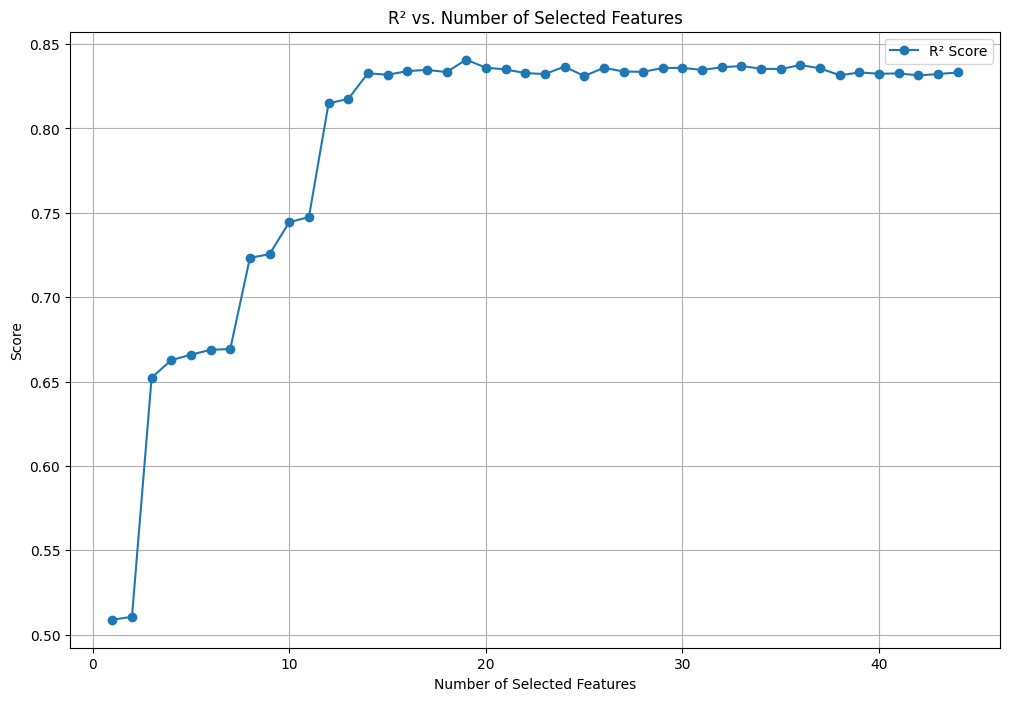

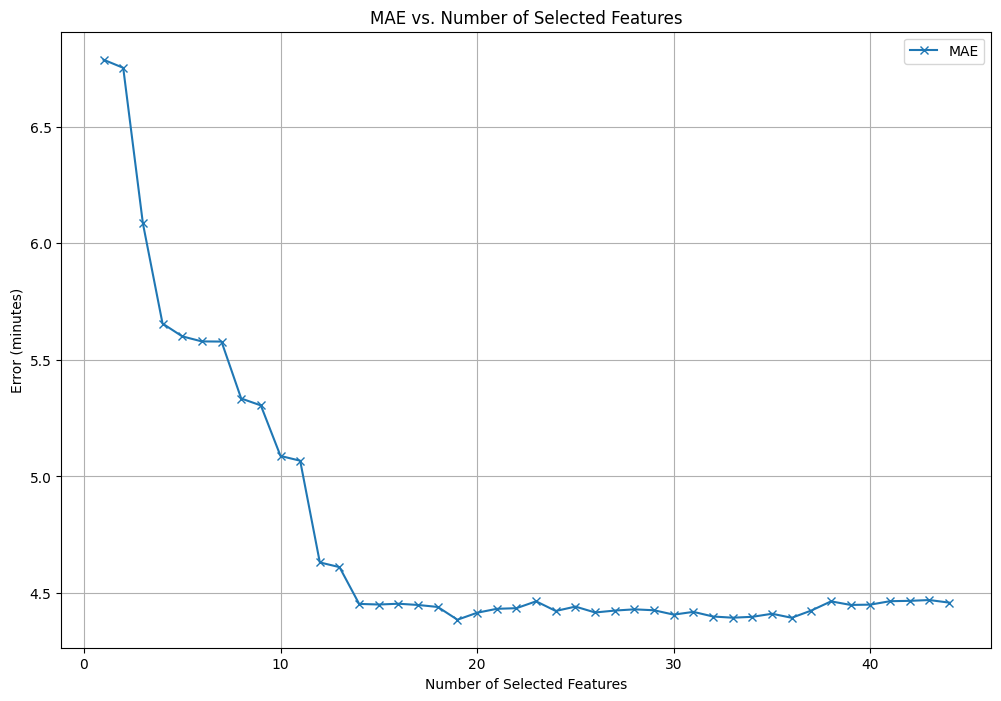

In [346]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(num_features, r2_scores, marker='o', label='R² Score')
# plt.plot(num_features, mae_scores, marker='x', label='MAE')
# plt.plot(num_features, mse_scores, marker='s', label='MSE')
plt.xlabel('Number of Selected Features')
plt.ylabel('Score')
plt.title('R² vs. Number of Selected Features')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(num_features, mae_scores, marker='x', label='MAE')
plt.xlabel('Number of Selected Features')
plt.ylabel('Error (minutes)')
plt.title('MAE vs. Number of Selected Features')
plt.legend()
plt.grid(True)
plt.show()

## Fine-tune the model using Feature Importance results

In [347]:
new_features = feature_importance.feature.values[:optimal_num_features]

In [348]:
new_features

array(['route_hour_pattern_median_arrival_delay',
       'route_hour_pattern_median_departure_delay',
       'route_hour_pattern_rolling_arrival_delay',
       'route_station_avg_total_dep',
       'route_hour_pattern_avg_arrival_delay',
       'route_station_avg_total_arr',
       'route_hour_pattern_rolling_departure_delay', 'day',
       'route_station_std_total_dep', 'trip_distance', 'trip_duration',
       'day_of_week', 'route_station_median_total_arr',
       'route_day_of_week_pattern_avg_arrival_delay',
       'route_day_of_week_pattern_avg_departure_delay', 'is_last_trip',
       'route_station_median_total_dep', 'number_of_stations',
       'route_day_of_week_pattern_median_arrival_delay'], dtype=object)

In [349]:
X_train = train_data[new_features]
y_train = train_data[["arrival_delay", "departure_delay"]]
X_test = test_data[new_features]
y_test = test_data[["arrival_delay", "departure_delay"]]

In [352]:
model = XGBRegressor(
    n_estimators=300,
    max_depth=9,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=0.8,
    random_state=42,
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [353]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"\n📊 SINGLE STATION RESULTS:")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.2f} minutes")

# Feature importance
feature_importance = pd.DataFrame(
    {"feature": new_features, "importance": model.feature_importances_}
).sort_values("importance", ascending=False)

print(f"\n🔍 TOP 20 FEATURES:")
for i, (_, row) in enumerate(feature_importance.head(20).iterrows()):
    print(f"{i+1:2d}. {row['feature']:<50} {row['importance']:.3f}")


📊 SINGLE STATION RESULTS:
MSE: 68.25
R²: 0.849
MAE: 4.13 minutes

🔍 TOP 20 FEATURES:
 1. route_hour_pattern_median_arrival_delay            0.361
 2. route_hour_pattern_median_departure_delay          0.160
 3. route_hour_pattern_rolling_arrival_delay           0.070
 4. day_of_week                                        0.040
 5. route_hour_pattern_rolling_departure_delay         0.035
 6. day                                                0.032
 7. trip_duration                                      0.030
 8. route_day_of_week_pattern_median_arrival_delay     0.029
 9. trip_distance                                      0.029
10. number_of_stations                                 0.027
11. route_day_of_week_pattern_avg_arrival_delay        0.026
12. route_hour_pattern_avg_arrival_delay               0.025
13. route_day_of_week_pattern_avg_departure_delay      0.025
14. route_station_avg_total_arr                        0.023
15. route_station_median_total_dep                     0.019

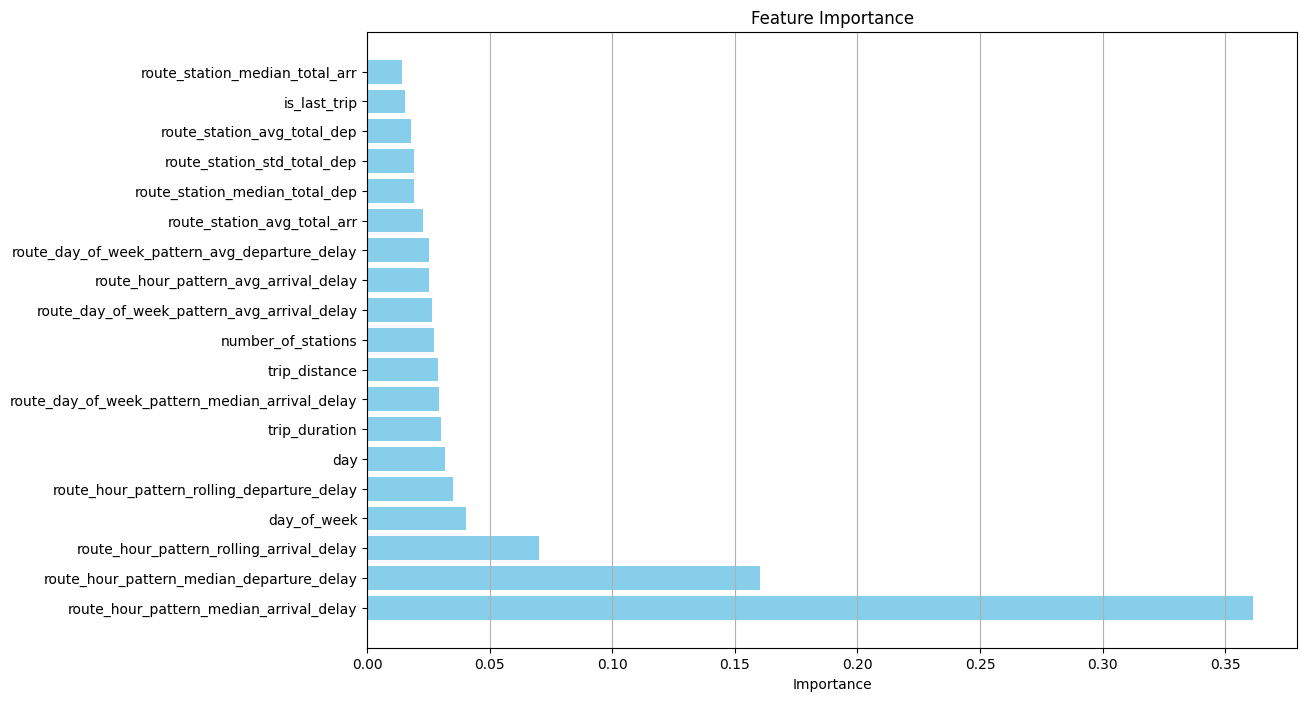

In [367]:
# plot top features
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.grid(axis='x')
plt.savefig('../screenshots/feature_importance.png', bbox_inches='tight')
plt.show()

In [355]:
# k fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    fold_model = XGBRegressor(
        n_estimators=1000,
        max_depth=9,
        learning_rate=0.1,
        subsample=1.0,
        colsample_bytree=0.8,
        random_state=42,
    )
    fold_model.fit(X_train_fold, y_train_fold)
    y_val_pred = fold_model.predict(X_val_fold)

    fold_mse = mean_squared_error(y_val_fold, y_val_pred)
    fold_r2 = r2_score(y_val_fold, y_val_pred)
    fold_mae = mean_absolute_error(y_val_fold, y_val_pred)

    cv_results.append({
        'mse': fold_mse,
        'r2': fold_r2,
        'mae': fold_mae
    })
cv_results_df = pd.DataFrame(cv_results)
print(f"\n📊 K-FOLD CROSS-VALIDATION RESULTS:")
cv_results_df


📊 K-FOLD CROSS-VALIDATION RESULTS:


,mse,r2,mae
0,69.910477,0.849855,4.264626
1,70.110367,0.841600,4.259410
2,70.486816,0.837588,4.214136
3,84.214233,0.823764,4.375305
4,74.994644,0.824562,4.288414


In [356]:
# test model training and inference speed
for _ in range(10):
    start_time = perf_counter()
    model.fit(X_train, y_train)
    end_time = perf_counter()
    print(f"Training time: {end_time - start_time:.4f} seconds")

Training time: 19.0906 seconds
Training time: 21.8042 seconds
Training time: 19.7602 seconds
Training time: 19.4122 seconds
Training time: 22.2364 seconds
Training time: 19.6944 seconds
Training time: 18.8951 seconds
Training time: 19.9717 seconds
Training time: 19.5273 seconds
Training time: 19.8473 seconds


## Export the model and the feature importance results

In [357]:
# export the model and the feature importance results
joblib.dump(model, "../models/TripsDelayXGBoostModel_v1.0.joblib")
json.dump(feature_importance.to_dict(orient='records'), open("../models/TripsDelayXGBoostModel_feature_importance_v1.0.json", "w"))

# save model metrics
json.dump({
    "model": "XGBRegressor",
    "file_name": "TripsDelayXGBoostModel_v1.0",
    "version": "v1.0",
    "mse": mse,
    "r2": r2,
    "mae": mae,
}, open("../models/TripsDelayXGBoostModel_metrics_v1.0.json", "w"))

# save label encoders
joblib.dump(label_encoders, '../models/label_encoders_v1.0.joblib')

['../models/label_encoders_v1.0.joblib']